In [146]:
from pathlib import Path
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import scipy
import sklearn.decomposition

In [199]:
csv_files = {x.stem: x for x in (Path("../data").glob("*.csv"))}

In [200]:
all_results_df = pd.read_csv(csv_files["all_results"])
all_results_df.columns

Index(['model', 'num_param', 'memT', 'memR', 'memA', 'memM', 'energy', 'co2',
       'train_time', 'infer_time', 'test_00', 'inf_time', 'tr_acc', 'test_01',
       'test_02', 'test_03', 'test_04', 'test_05', 'test_06', 'test_07',
       'test_08', 'test_09', 'pretrain', 'type', 'efficient', 'dataset',
       'pen'],
      dtype='object')

In [201]:
# idx = (all_results_df["dataset"] == "derma") | (all_results_df["dataset"] == "derma_pt")
idx = (all_results_df["dataset"] == "derma")
df = pd.DataFrame(all_results_df[idx])
df = df.sort_values("num_param")
df

,model,num_param,memT,memR,memA,memM,energy,co2,train_time,infer_time,...,test_05,test_06,test_07,test_08,test_09,pretrain,type,efficient,dataset,pen
393,dla46x_c,1068440,25.435111,3.001025,0.038321,2.267537,0.018471,0.969729,11.889799,0,...,0.694052,0.708669,0.722782,0.731855,0.723790,0.0,CNN,0,derma,0.674952
394,dla46_c,1301400,25.435111,2.520777,0.042073,1.882373,0.016436,1.536767,10.464308,0,...,0.698085,0.711694,0.695565,0.706149,0.704637,0.0,CNN,0,derma,0.662012
395,mobilevitv2_050,1370593,25.435111,3.091202,0.060189,2.885807,0.015261,1.434517,9.933567,0,...,0.665323,0.693044,0.679435,0.680948,0.681452,0.0,Other,1,derma,0.643010
396,mobilenetv2_050,1968680,25.435111,2.227175,0.053616,1.934997,0.010583,1.010668,7.320693,0,...,0.652722,0.671875,0.670867,0.673891,0.684476,0.0,CNN,1,derma,0.657229
397,semnasnet_075,2912278,25.435111,2.791309,0.068774,2.116848,0.014516,1.386263,9.723404,0,...,0.699093,0.696069,0.708669,0.674899,0.701109,0.0,Other,1,derma,0.663386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,ecaresnet269d,102093077,25.435111,19.860029,1.667829,19.072327,0.173975,9.177201,105.954078,0,...,0.717742,0.725302,0.727823,0.735383,0.731855,0.0,Other,1,derma,0.435230
520,legacy_senet154,115088984,25.435111,18.150851,1.861255,16.598430,0.184867,9.566861,112.701546,0,...,0.714718,0.722278,0.726310,0.732359,0.748992,0.0,CNN,0,derma,0.434399
521,resnetrs270,129861448,25.435111,20.963131,2.113233,20.127319,0.180650,9.393810,110.042049,0,...,0.719254,0.725806,0.738911,0.743448,0.746472,0.0,CNN,0,derma,0.437125
522,vgg11,132863336,25.435111,6.343885,2.105292,4.500173,0.046186,2.447834,29.097516,0,...,0.683972,0.705141,0.712702,0.707157,0.714718,0.0,CNN,0,derma,0.605217


In [202]:
df["test_profile"] = df[[f"test_{i:02d}" for i in range(10)]].values.tolist()

In [203]:
test_profile = np.array(df["test_profile"].tolist())

In [204]:
peak_profile = np.zeros_like(test_profile)
peak_profile[:, 0] = test_profile[:, 0]
for i in range(1, peak_profile.shape[-1]):
    peak_profile[:, i] = np.maximum(peak_profile[:, i-1], test_profile[:, i])
peak_profile

array([[0.66129032, 0.66129032, 0.66280242, ..., 0.72278226, 0.73185484,
        0.73185484],
       [0.59828629, 0.66733871, 0.66733871, ..., 0.7172379 , 0.7172379 ,
        0.7172379 ],
       [0.66481855, 0.69707661, 0.70766129, ..., 0.70766129, 0.70766129,
        0.70766129],
       ...,
       [0.67842742, 0.68397177, 0.69052419, ..., 0.73891129, 0.74344758,
        0.74647177],
       [0.66935484, 0.67590726, 0.68649194, ..., 0.71270161, 0.71270161,
        0.71471774],
       [0.66885081, 0.67086694, 0.67540323, ..., 0.70362903, 0.70362903,
        0.70362903]])

In [205]:
epoch_time = (df["train_time"].values / 10).reshape(-1, 1) * np.arange(10).reshape(1, -1)
epoch_time

array([[ 0.        ,  1.18897994,  2.37795987, ...,  8.32285955,
         9.51183949, 10.70081942],
       [ 0.        ,  1.04643075,  2.09286151, ...,  7.32501528,
         8.37144604,  9.41787679],
       [ 0.        ,  0.9933567 ,  1.98671341, ...,  6.95349693,
         7.94685364,  8.94021034],
       ...,
       [ 0.        , 11.00420494, 22.00840988, ..., 77.02943459,
        88.03363953, 99.03784447],
       [ 0.        ,  2.90975156,  5.81950312, ..., 20.36826091,
        23.27801247, 26.18776402],
       [ 0.        ,  4.00645766,  8.01291533, ..., 28.04520364,
        32.0516613 , 36.05811896]])

In [206]:
sample_times = np.arange(0, 120, 10)
peak_profile_time = np.zeros((peak_profile.shape[0], sample_times.shape[0]))
for i in range(0, peak_profile.shape[0]):
    peak_profile_time[i] = np.interp(sample_times, epoch_time[i], peak_profile[i])
peak_profile_time

array([[0.66129032, 0.73185484, 0.73185484, ..., 0.73185484, 0.73185484,
        0.73185484],
       [0.59828629, 0.7172379 , 0.7172379 , ..., 0.7172379 , 0.7172379 ,
        0.7172379 ],
       [0.66481855, 0.70766129, 0.70766129, ..., 0.70766129, 0.70766129,
        0.70766129],
       ...,
       [0.67842742, 0.68346582, 0.68932829, ..., 0.74398798, 0.74647177,
        0.74647177],
       [0.66935484, 0.69707661, 0.71174475, ..., 0.71471774, 0.71471774,
        0.71471774],
       [0.66885081, 0.67965297, 0.68447581, ..., 0.70362903, 0.70362903,
        0.70362903]])

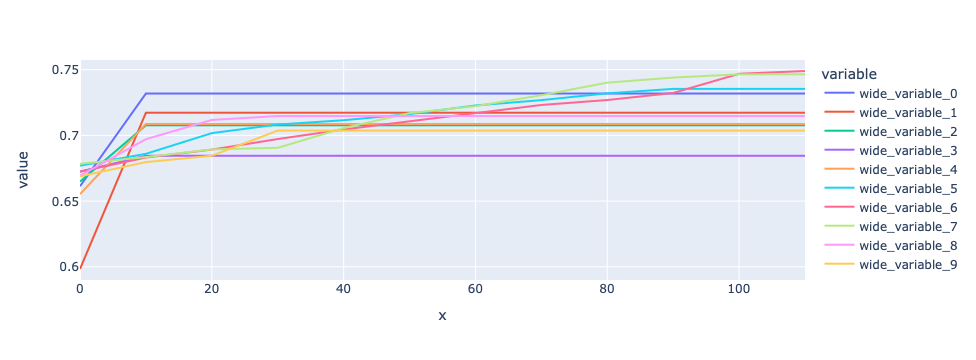

In [207]:
px.line(x=sample_times, y=peak_profile_time[:5].tolist() + peak_profile_time[-5:].tolist())

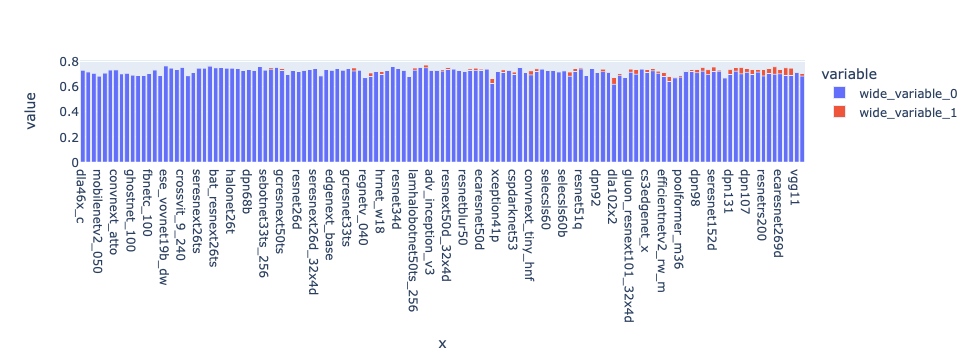

In [209]:
px.bar(y=[peak_profile_time[:, 2], peak_profile_time[:, -1]-peak_profile_time[:, 2]], x=df["model"])

In [117]:
pca = sklearn.decomposition.PCA()
pca_profile = pca.fit_transform(test_profile)
pca.explained_variance_ratio_, pca.mean_

(array([0.77722393, 0.09270233, 0.03353497, 0.02643649, 0.0195411 ,
        0.01705595, 0.01424864, 0.01051721, 0.00873938]),
 array([0.75158143, 0.76947167, 0.77264715, 0.77839166, 0.78257365,
        0.78813904, 0.79223229, 0.79351197, 0.79400127]))

In [128]:
np.corrcoef(test_profile, rowvar=False)

array([[1.        , 0.85227128, 0.80103747, 0.79154638, 0.78125983,
        0.80613639, 0.79391088, 0.799557  , 0.59661009],
       [0.85227128, 1.        , 0.82849703, 0.82941304, 0.75843499,
        0.81320895, 0.77753577, 0.78160116, 0.6696136 ],
       [0.80103747, 0.82849703, 1.        , 0.80964559, 0.79801394,
        0.75801227, 0.78228198, 0.7856716 , 0.60807928],
       [0.79154638, 0.82941304, 0.80964559, 1.        , 0.85110014,
        0.83759285, 0.80343379, 0.80565307, 0.65079551],
       [0.78125983, 0.75843499, 0.79801394, 0.85110014, 1.        ,
        0.79510812, 0.78095797, 0.77968602, 0.62320192],
       [0.80613639, 0.81320895, 0.75801227, 0.83759285, 0.79510812,
        1.        , 0.8678793 , 0.89452844, 0.67207382],
       [0.79391088, 0.77753577, 0.78228198, 0.80343379, 0.78095797,
        0.8678793 , 1.        , 0.85716777, 0.64403158],
       [0.799557  , 0.78160116, 0.7856716 , 0.80565307, 0.77968602,
        0.89452844, 0.85716777, 1.        , 0.67528792],


In [130]:
np.std(test_profile, axis=1)

array([0.05015733, 0.02393127, 0.01345405, 0.03149693, 0.00616995,
       0.02491411, 0.02465786, 0.0150217 , 0.01126486, 0.00765797,
       0.02293898, 0.01375729, 0.01191811, 0.02628794, 0.01494467,
       0.01593969, 0.01492829, 0.02172405, 0.03893123, 0.04678053,
       0.02632788, 0.02675729, 0.01833465, 0.0210892 , 0.01637758,
       0.03106892, 0.01114895, 0.02435609, 0.02011223, 0.01909829,
       0.02529751, 0.01858931, 0.01902161, 0.02652348, 0.02505683,
       0.05840564, 0.01100951, 0.06526453, 0.01840074, 0.02487467,
       0.01818832, 0.01617932, 0.02975873, 0.01969528, 0.02338081,
       0.0395651 , 0.0141431 , 0.01347652, 0.01473544, 0.02165971,
       0.02420171, 0.02712528, 0.02030514, 0.01504799, 0.03126876,
       0.02336511, 0.03498212, 0.03528741, 0.02007773, 0.04131296,
       0.01863481, 0.01936008, 0.02608854, 0.05580537, 0.01648561,
       0.03868222, 0.03876071, 0.01957419, 0.02972962, 0.02743375,
       0.02006445, 0.02205333, 0.02320374, 0.0175002 , 0.02963

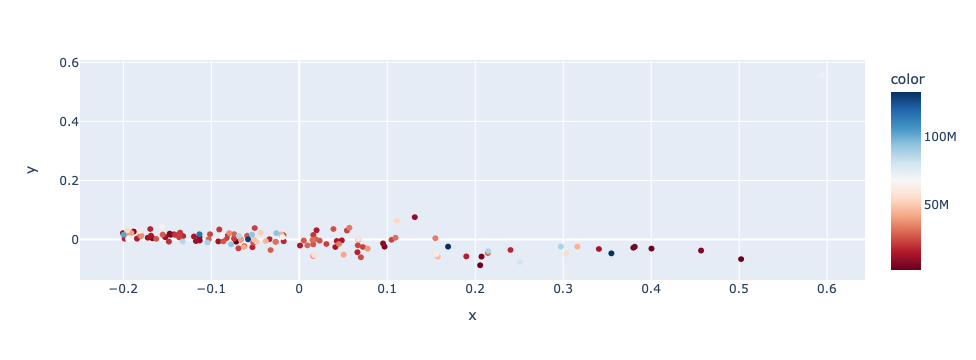

In [121]:
px.scatter(x=pca_profile[:, 0], y=pca_profile[:, 1], hover_name=df["model"], opacity=1.0, color=df["num_param"], color_continuous_scale="RdBu")

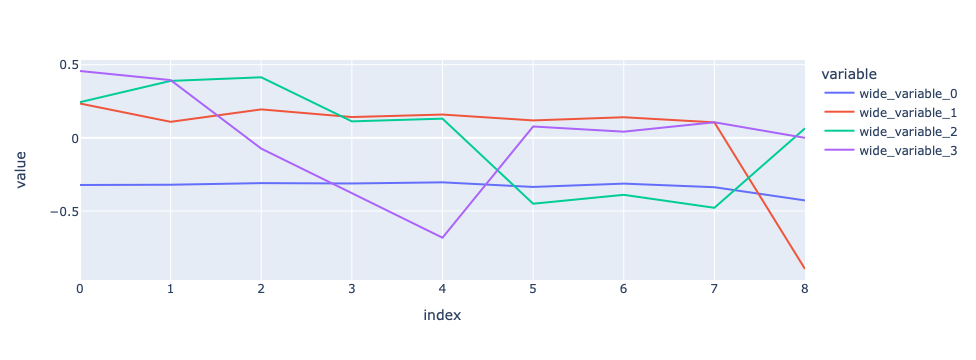

In [116]:
px.line(y=[pca.components_[i] for i in range(4)])

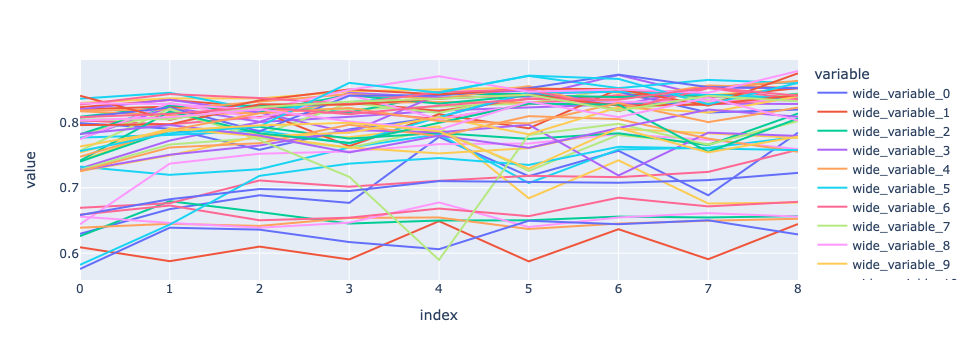

In [122]:
plot_df = df.iloc[:50]
# plot_df = df[df["model"] == "dm_nfnet_f0"]
px.line(y=plot_df["test_profile"].tolist(), labels=plot_df["model"].tolist())

In [102]:
help(px.line)

Help on function line in module plotly.express._chart_types:

line(data_frame=None, x=None, y=None, line_group=None, color=None, line_dash=None, symbol=None, hover_name=None, hover_data=None, custom_data=None, text=None, facet_row=None, facet_col=None, facet_col_wrap=0, facet_row_spacing=None, facet_col_spacing=None, error_x=None, error_x_minus=None, error_y=None, error_y_minus=None, animation_frame=None, animation_group=None, category_orders=None, labels=None, orientation=None, color_discrete_sequence=None, color_discrete_map=None, line_dash_sequence=None, line_dash_map=None, symbol_sequence=None, symbol_map=None, markers=False, log_x=False, log_y=False, range_x=None, range_y=None, line_shape=None, render_mode='auto', title=None, template=None, width=None, height=None) -> plotly.graph_objs._figure.Figure
        In a 2D line plot, each row of `data_frame` is represented as vertex of
        a polyline mark in 2D space.
        
    Parameters
    ----------
    data_frame: DataFrame o

In [52]:
df[df["model"] == "nasnetalarge"]

,model,num_param,memT,memR,memA,memM,energy,co2,train_time,infer_time,...,test_05,test_06,test_07,test_08,test_09,pretrain,type,efficiency,dataset,test_profile
122,nasnetalarge,88753150,25.435111,21.130904,1.418934,20.245244,0.174988,13.342814,107.049753,0,...,0.826109,0.835181,0.827621,0.847278,0.836190,1.0,Other,0,derma_pt,"[0.7636088709677419, 0.7948588709677419, 0.826..."
253,nasnetalarge,88753150,25.435111,21.336424,1.389253,20.229133,0.227686,7.855172,138.659011,0,...,0.681516,0.675199,0.679521,0.650931,0.685173,NaN,Other,0,lidc,"[0.7134308510638298, 0.6675531914893617, 0.667..."
384,nasnetalarge,88753150,25.435111,21.149778,1.414126,20.229133,0.038495,4.580926,23.796479,0,...,0.650598,0.620013,0.660239,0.650598,0.654255,0.0,Other,0,lidc_small,"[0.6392952127659575, 0.6276595744680851, 0.626..."
515,nasnetalarge,88753150,25.435111,21.130904,1.418934,20.245244,0.174608,9.472494,107.274882,0,...,0.717238,0.725806,0.734879,0.729839,0.710685,0.0,Other,0,derma,"[0.6925403225806451, 0.6829637096774194, 0.719..."
646,nasnetalarge,88753150,25.435111,21.130904,1.412227,20.245244,0.027606,3.643978,17.277176,0,...,0.669355,0.669355,0.624496,0.604335,0.666331,0.0,Other,0,derma_small,"[0.1078629032258064, 0.6693548387096774, 0.668..."
777,nasnetalarge,88753150,25.435111,21.281898,1.401904,20.245244,0.012814,6.086833,8.538226,0,...,0.109879,0.109879,0.109879,0.106351,0.106855,0.0,Other,0,derma_smallest,"[0.6693548387096774, 0.1098790322580645, 0.109..."
908,nasnetalarge,88753150,25.435111,21.181235,1.397316,20.229133,0.112262,6.623444,68.602174,0,...,0.916118,0.937500,0.911184,0.968750,0.927632,0.0,Other,0,pneumonia,"[0.9342105263157896, 0.919407894736842, 0.9440..."
1039,nasnetalarge,88753150,25.435111,21.149778,1.404201,20.229133,0.013618,6.468557,9.031973,0,...,0.904605,0.848684,0.876645,0.893092,0.899671,0.0,Other,0,pneumonia_small,"[0.789473684210526, 0.876644736842105, 0.74013..."
